## Predict Spend

Given the historic data with clicks, impressions, spend, reach, and so on, build a model that can predict the probability of a specific _spend_ will result in clicks, impressions, reach, and so on.

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

In [2]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
import tensorflow_probability as tfp
import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
# from rezaware.modules.etl.loader import sparkRDBM as db
from rezaware.modules.etl.loader import sparkFile as file
# from rezaware.modules.etl.loader import __propAttr__ as attr

''' restart initiate classes '''
if debug:
    import importlib
    # db = importlib.reload(db)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write BigQuery dataset for hypothese testing"
# clsSDB = db.dataWorkLoads(
#     desc=__desc__,
#     db_type = 'bigquery',
#     db_driver=None,
#     db_hostIP=None,
#     db_port = None,
#     db_name = None,
#     db_schema='combined_data_facebook_ads',
#     spark_partitions=None,
#     spark_format = 'bigquery',
#     spark_save_mode=None,
#     # spark_jar_dir = _jar,
# )
clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    store_mode='local-fs',
    store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
# if clsSDB.session:
#     clsSDB._session.stop
print("\n%s class initialization and load complete!" % __desc__)

2025-02-19 07:48:49.749029: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-19 07:48:52.103808: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-19 07:48:53.237269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739922534.354224  406752 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739922534.552397  406752 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 07:48:56.249664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

All functional __PROPATTR__-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
All functional APP-libraries in REZAWARE-package of REZAWARE-module imported successfully!
__propAttr__ Class initialization complete
sparkFile Class initialization complete

read and write BigQuery dataset for hypothese testing class initialization and load complete!


## Load Data

In [3]:
options = {
    "inferSchema":True,
    "header":True,
    "delimiter":",",
    "pathGlobFilter":'*.csv',
    "recursiveFileLookup":True,
}

sdf=clsFile.read_files_to_dtype(
    as_type = "SPARK",      # optional - define the data type to return
    folder_path="mining/data/budget/",  # optional - relative path, w.r.t. self.storeRoot
    file_name="complete-60-accounts.csv",  # optional - name of the file to read
    file_type=None,  # optional - read all the files of same type
    **options,
)
print("Loaded %d rows" % sdf.count())

25/02/19 07:49:44 WARN Utils: Your hostname, Waidy-Think-Three resolves to a loopback address: 127.0.1.1; using 192.168.2.82 instead (on interface enp0s25)
25/02/19 07:49:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/02/19 07:49:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
                                                                                

Loaded 61513 rows


## Currency Convert the Spend

In [4]:
### USE python currency-converter librabry with date
sdf = sdf.withColumn(
    "spend_usd",
    F.when(F.col('account_currency').isin('CAD'), F.col('spend') * 0.70)
     .when(F.col('account_currency').isin('EUR'), F.col('spend') * 1.05)
     .when(F.col('account_currency').isin('THB'), F.col('spend') * 0.03)
     .when(F.col('account_currency').isin('INR'), F.col('spend') * 0.012)
     .when(F.col('account_currency').isin('USD'), F.col('spend') * 1.00)
     .otherwise(F.col('spend') * 1.00)
)

sdf.printSchema()

root
 |-- account_id: long (nullable = true)
 |-- ad_id: long (nullable = true)
 |-- adset_id: long (nullable = true)
 |-- campaign_id: long (nullable = true)
 |-- updated_time: date (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- frequency: double (nullable = true)
 |-- reach: integer (nullable = true)
 |-- CTR: double (nullable = true)
 |-- CPC: double (nullable = true)
 |-- CPM: double (nullable = true)
 |-- ROAS: double (nullable = true)
 |-- social_spend: double (nullable = true)
 |-- spend: double (nullable = true)
 |-- click: integer (nullable = true)
 |-- auction_bid: integer (nullable = true)
 |-- goal: string (nullable = true)
 |-- purchase_value: double (nullable = true)
 |-- account_currency: string (nullable = true)
 |-- purchase: double (nullable = true)
 |-- fb_pixel_view_value: double (nullable = true)
 |-- fb_pixel_purchase_value: double (nullable = true)
 |-- fb_pixel_add_to_cart_value: double (nullable = true)
 |-- mobile_app_purchase_value: string

In [8]:
type(ts['updated_time'])

pyspark.sql.column.Column

In [41]:
import pandas as pd

gdf=sdf.groupBy('updated_time').agg(F.mean('click'))\
    .orderBy('updated_time').toPandas()
gdf['updated_time']=pd.to_datetime(gdf['updated_time'])
gdf['day_of_week']=gdf['updated_time'].dt.day_name()
dow_df = gdf.groupby(['updated_time','day_of_week'],as_index=False, sort=False)\
            ['avg(click)'].sum('avg(click)')
dow_df=dow_df.rename(columns={'avg(click)':'click_sum'})
dow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   updated_time  249 non-null    datetime64[ns]
 1   day_of_week   249 non-null    object        
 2   click_sum     249 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.0+ KB


<Axes: xlabel='updated_time'>

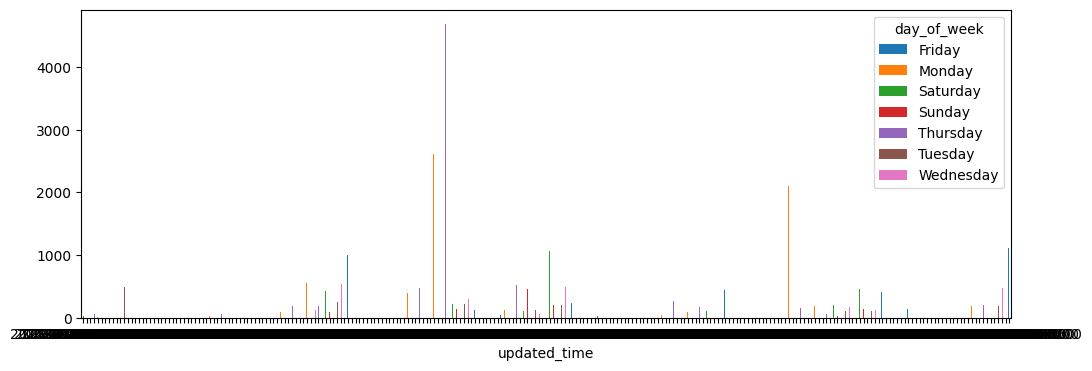

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_df = dow_df.pivot(index="updated_time", 
                       columns="day_of_week", values="click_sum")

fig, axs = plt.subplots(figsize=(12, 4))

plot_df.plot(kind='bar', rot=0, ax=axs)

## Filtered Dataframe
* goal = OFFSITE_CONVERSIONS
* columns = spend_usd, CPC, CPM, CTR, ROAS,<br><tab><tab>click, impressions, frequency, reach
* column value >= mean + 2 x sigma (95 percentile)
* account_currency = USD (market segment)

In [6]:
_data_df= sdf.select('spend_usd','CPC', 'CPM', 'CTR', 'ROAS', 
                     'impressions', 'click', 'reach', 'frequency')\
            .where(F.col('goal').isin('OFFSITE_CONVERSIONS') & \
                  F.col('account_currency').isin('USD'))\
            .dropna().toPandas()
print(_data_df.shape)
''' keep 95 percentile of the data '''
for _col in _data_df.columns:
    _data_df = _data_df[_data_df[_col]<=\
                    _data_df[_col].mean()+2*_data_df[_col].std()]
# _data_df = _data_df.sample(n=1000)

print("data shape:", _data_df.shape)
print("some stats:\n", _data_df.describe())

(5410, 9)
data shape: (3737, 9)
some stats:
          spend_usd          CPC          CPM          CTR         ROAS  \
count  3737.000000  3737.000000  3737.000000  3737.000000  3737.000000   
mean     88.289912     1.427435    33.560158     3.443672    10.031168   
std      85.953397     0.928936    11.957310     2.596982    23.174951   
min       0.240000     0.000000     3.488372     0.000000     0.014839   
25%      22.650000     0.735714    24.626659     1.546790     1.703885   
50%      58.900000     1.236289    32.082574     2.606865     3.638252   
75%     127.970000     1.917561    41.399177     4.648568     8.437335   
max     515.080000     4.377500    64.329502    12.539185   290.727273   

        impressions        click        reach    frequency  
count   3737.000000  3737.000000  3737.000000  3737.000000  
mean    2643.025689    88.822050  2011.131924     1.291852  
std     2384.212747   104.550725  1721.912136     0.176863  
min        8.000000     0.000000     7.00000

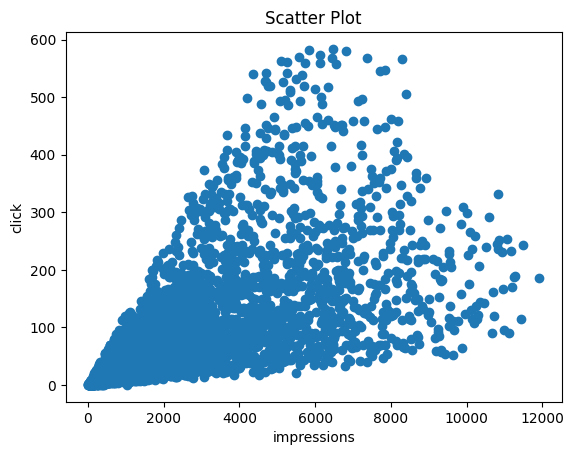

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

_x_col, _y_col = 'impressions', 'click' #, 'reach'
plt.scatter(_data_df[_x_col],_data_df[_y_col])
plt.title("Scatter Plot")
plt.xlabel(_x_col)
plt.ylabel(_y_col)
plt.show()

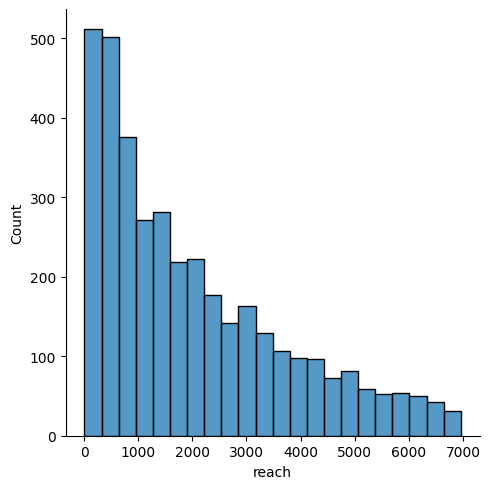

In [12]:
import seaborn as sns 

# sns.displot(_data_df, x=_x_col)
sns.displot(_data_df, x=_y_col)

## Fit with Normal distribution

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions
tfb = tfp.bijectors

# Example historic data (replace with your actual data)
# Each row represents a historic data point: [Spend, CPC, CPM, CTR, ROAS]
# historic_data = np.array([
#     [100, 0.5, 10, 0.02, 4.0],
#     [200, 0.6, 12, 0.03, 3.5],
#     [300, 0.7, 15, 0.04, 3.0],
#     # Add more data points here
# ])
historic_data = np.array(_data_df)

# Split the data into input (Spend) and outputs (CPC, CPM, CTR, ROAS)
spend = historic_data[:, 0].astype(np.float32)  # Ensure float32 for TensorFlow
cpc = historic_data[:, 1].astype(np.float32)
cpm = historic_data[:, 2].astype(np.float32)
ctr = historic_data[:, 3].astype(np.float32)
roas = historic_data[:, 4].astype(np.float32)

# Scale the Spend data to improve numerical stability
spend_mean = np.mean(spend)
spend_std = np.std(spend)
spend_scaled = (spend - spend_mean) / spend_std

# Define the probabilistic model
def model():
    # Priors for the parameters
    alpha_cpc = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_cpc")
    beta_cpc = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_cpc")

    alpha_cpm = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_cpm")
    beta_cpm = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_cpm")
    
    alpha_ctr = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_ctr")
    beta_ctr = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_ctr")
    
    alpha_roas = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_roas")
    beta_roas = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_roas")
    
    # Likelihoods
    cpc_pred = yield tfd.Normal(loc=alpha_cpc + beta_cpc * spend_scaled, scale=0.1, name="cpc_pred")
    cpm_pred = yield tfd.Normal(loc=alpha_cpm + beta_cpm * spend_scaled, scale=0.1, name="cpm_pred")
    ctr_pred = yield tfd.Normal(loc=alpha_ctr + beta_ctr * spend_scaled, scale=0.01, name="ctr_pred")
    roas_pred = yield tfd.Normal(loc=alpha_roas + beta_roas * spend_scaled, scale=0.1, name="roas_pred")

# Define the joint distribution
joint_distribution = tfd.JointDistributionCoroutineAutoBatched(model)

# Define the log probability function
def log_prob(alpha_cpc, beta_cpc, alpha_cpm, beta_cpm, alpha_ctr, beta_ctr, alpha_roas, beta_roas):
    return joint_distribution.log_prob(
        alpha_cpc=alpha_cpc,
        beta_cpc=beta_cpc,
        alpha_cpm=alpha_cpm,
        beta_cpm=beta_cpm,
        alpha_ctr=alpha_ctr,
        beta_ctr=beta_ctr,
        alpha_roas=alpha_roas,
        beta_roas=beta_roas,
        cpc_pred=cpc,
        cpm_pred=cpm,
        ctr_pred=ctr,
        roas_pred=roas,
    )

# Use MCMC to sample from the posterior
num_results = 10000  # Increase the number of samples
num_burnin_steps = 1000  # Increase the burn-in steps

# Initialize the chain with reasonable values
initial_chain_state = [
    tf.constant(0.5),  # alpha_cpc
    tf.constant(0.1),  # beta_cpc
    tf.constant(10.0),  # alpha_cpm
    tf.constant(0.1),  # beta_cpm
    tf.constant(0.02),  # alpha_ctr
    tf.constant(0.01),  # beta_ctr
    tf.constant(4.0),  # alpha_roas
    tf.constant(0.1),  # beta_roas
]

# Define the MCMC kernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=10,
    step_size=0.05,  # Adjusted step size
)

# Run the MCMC sampler
@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_chain_state,
        kernel=hmc_kernel,
        trace_fn=None,
    )

# Run the chain and get samples
samples = run_chain()

# Extract the posterior samples
alpha_cpc_samples, beta_cpc_samples, alpha_cpm_samples, beta_cpm_samples, \
alpha_ctr_samples, beta_ctr_samples, alpha_roas_samples, beta_roas_samples = samples

print("Completed generating samples")

## Fit with Gamma distribution

In [69]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions
tfb = tfp.bijectors

# Example historic data (replace with your actual data)
# Each row represents a historic data point: [Spend, CPC, CPM, CTR, ROAS]
# historic_data = np.array([
#     [100, 0.5, 10, 0.02, 4.0],
#     [200, 0.6, 12, 0.03, 3.5],
#     [300, 0.7, 15, 0.04, 3.0],
#     # Add more data points here
# ])
historic_data = np.array(_data_df)

# Split the data into input (Spend) and outputs (CPC, CPM, CTR, ROAS)
spend = historic_data[:, 0].astype(np.float32)  # Ensure float32 for TensorFlow
cpc = historic_data[:, 1].astype(np.float32)
cpm = historic_data[:, 2].astype(np.float32)
ctr = historic_data[:, 3].astype(np.float32)
roas = historic_data[:, 4].astype(np.float32)

# Scale the Spend data to improve numerical stability
spend_mean = np.mean(spend)
spend_std = np.std(spend)
spend_scaled = (spend - spend_mean) / spend_std

# Define the probabilistic model
def model():
    # Priors for the parameters (using Gamma distributions for non-negativity)
    alpha_cpc = yield tfd.Gamma(
        concentration=1.0, 
        rate=1.0, 
        name="alpha_cpc")
    beta_cpc = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_cpc")
    
    alpha_cpm = yield tfd.Gamma(concentration=1.0, rate=1.0, name="alpha_cpm")
    beta_cpm = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_cpm")
    
    alpha_ctr = yield tfd.Gamma(concentration=1.0, rate=1.0, name="alpha_ctr")
    beta_ctr = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_ctr")
    
    alpha_roas = yield tfd.Gamma(concentration=1.0, rate=1.0, name="alpha_roas")
    beta_roas = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_roas")
    
    # Likelihoods (using Gamma distributions for non-negativity)
    cpc_pred = yield tfd.Gamma(
        concentration=alpha_cpc + beta_cpc * spend_scaled,
        rate=1.0,
        name="cpc_pred"
    )
    cpm_pred = yield tfd.Gamma(
        concentration=alpha_cpm + beta_cpm * spend_scaled,
        rate=1.0,
        name="cpm_pred"
    )
    ctr_pred = yield tfd.Gamma(
        concentration=alpha_ctr + beta_ctr * spend_scaled,
        rate=1.0,
        name="ctr_pred"
    )
    roas_pred = yield tfd.Gamma(
        concentration=alpha_roas + beta_roas * spend_scaled,
        rate=1.0,
        name="roas_pred"
    )

# Define the joint distribution
joint_distribution = tfd.JointDistributionCoroutineAutoBatched(model)

# Define the log probability function
def log_prob(alpha_cpc, beta_cpc, alpha_cpm, beta_cpm, alpha_ctr, beta_ctr, alpha_roas, beta_roas):
    return joint_distribution.log_prob(
        alpha_cpc=alpha_cpc,
        beta_cpc=beta_cpc,
        alpha_cpm=alpha_cpm,
        beta_cpm=beta_cpm,
        alpha_ctr=alpha_ctr,
        beta_ctr=beta_ctr,
        alpha_roas=alpha_roas,
        beta_roas=beta_roas,
        cpc_pred=cpc,
        cpm_pred=cpm,
        ctr_pred=ctr,
        roas_pred=roas,
    )

# Use MCMC to sample from the posterior
num_results = 2000  # Increase the number of samples
num_burnin_steps = 1000  # Increase the burn-in steps

# Initialize the chain with reasonable values
initial_chain_state = [
    tf.constant(1.0),  # alpha_cpc
    tf.constant(1.0),  # beta_cpc
    tf.constant(1.0),  # alpha_cpm
    tf.constant(1.0),  # beta_cpm
    tf.constant(1.0),  # alpha_ctr
    tf.constant(1.0),  # beta_ctr
    tf.constant(1.0),  # alpha_roas
    tf.constant(1.0),  # beta_roas
]

# Define the MCMC kernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=10,
    step_size=0.05,  # Adjusted step size
)

# Run the MCMC sampler
@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_chain_state,
        kernel=hmc_kernel,
        trace_fn=None,
    )

# Run the chain and get samples
samples = run_chain()

# Extract the posterior samples
alpha_cpc_samples, beta_cpc_samples, alpha_cpm_samples, beta_cpm_samples, \
alpha_ctr_samples, beta_ctr_samples, alpha_roas_samples, beta_roas_samples = samples

print('Completed generating Gama distribution data')


## Predict Performance for Spend Value

In [70]:
# Predict expected values for a given Spend
def predict(spend_value):
    # Scale the input Spend value
    spend_value_scaled = (spend_value - spend_mean) / spend_std
    
    # Compute predictions
    # cpc_pred = np.mean(alpha_cpc_samples + beta_cpc_samples * spend_value_scaled)
    # cpm_pred = np.mean(alpha_cpm_samples + beta_cpm_samples * spend_value_scaled)
    # ctr_pred = np.mean(alpha_ctr_samples + beta_ctr_samples * spend_value_scaled)
    # roas_pred = np.mean(alpha_roas_samples + beta_roas_samples * spend_value_scaled)
    cpc_pred = alpha_cpc_samples + beta_cpc_samples * spend_value_scaled
    cpm_pred = alpha_cpm_samples + beta_cpm_samples * spend_value_scaled
    ctr_pred = alpha_ctr_samples + beta_ctr_samples * spend_value_scaled
    roas_pred = alpha_roas_samples + beta_roas_samples * spend_value_scaled
    
    return cpc_pred, cpm_pred, ctr_pred, roas_pred

# Example prediction for a given Spend
spend_value = 72.56  # Replace with your desired Spend value
cpc_pred, cpm_pred, ctr_pred, roas_pred = predict(spend_value)

print(f"Expected CPC for Spend={spend_value}: {np.mean(cpc_pred)}")
print(f"Expected CPM for Spend={spend_value}: {np.mean(cpm_pred)}")
print(f"Expected CTR for Spend={spend_value}: {np.mean(ctr_pred)}")
print(f"Expected ROAS for Spend={spend_value}: {np.mean(roas_pred)}")

Expected CPC for Spend=72.56: 0.7994794249534607
Expected CPM for Spend=72.56: 0.7994794249534607
Expected CTR for Spend=72.56: 0.7994794249534607
Expected ROAS for Spend=72.56: 0.7994794249534607


In [ ]:
643.58975     4.068199    83.871559     3.038284     3.730636

In [43]:
_data_df[_data_df['spend_usd']<91]

,spend_usd,CPC,CPM,CTR,ROAS,click,impressions,frequency,reach
0,6.44,0.920000,11.398230,1.238938,18.636646,7,565,1.134538,498
1,5.00,1.000000,13.227513,1.322751,18.190000,5,378,1.192429,317
2,25.84,1.845714,29.397042,1.592719,9.854876,14,879,1.153543,762
3,16.29,1.086000,10.745383,0.989446,5.831799,15,1516,1.179767,1285
4,63.54,1.245882,55.933099,4.489437,8.462386,51,1136,1.347568,843
...,...,...,...,...,...,...,...,...,...
5397,72.56,0.980541,48.373333,4.933333,0.663589,74,1500,1.255230,1195
5398,49.69,1.014082,41.134106,4.056291,5.895150,49,1208,1.391705,868
5401,36.70,0.965789,34.819734,3.605313,3.442234,38,1054,1.299630,811
5406,19.59,0.932857,36.892655,3.954802,7.918836,21,531,1.149351,462
